# **Regression Neural Network Model**
Hyperparamters are tuned with Keras wrapper for Scikit-Learn(RandomizedSearch), Keras Tuner(RandomSearch, BayesianOPtimization)


In [ ]:
pip install -U keras-tuner

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import reciprocal, norm

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns
from numpy.random import seed

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

from kerastuner import HyperModel, HyperParameters, Objective
from kerastuner.tuners import RandomSearch, BayesianOptimization

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.4.1


In [3]:
data = pd. read_csv('train_wells_20210131_cln_bal.csv')
data=data[(data.DTCO<140) & (data.DTSM<240)]
data.describe()

,Depth,DTSM,DTCO,GAMMA,RHO
count,150625.000000,150625.000000,150625.000000,150625.000000,150625.000000
mean,8079.579824,132.023715,71.270285,82.517627,2.553487
std,3938.882276,34.998677,15.438664,44.815089,0.182163
min,559.000000,72.470100,40.459400,0.731000,1.223200
25%,5053.000000,104.310400,58.843400,46.972900,2.466800
50%,7877.000000,123.750900,70.195100,88.414200,2.589800
75%,11178.500000,151.105300,82.471600,111.434900,2.663100
max,18739.500000,239.998200,122.186300,623.161700,3.091600


In [4]:
cols=['GAMMA','RHO','DTCO']
#X = data[cols]
X = data[['Depth']+cols]
Y = data[['DTSM']]

In [5]:
seed(42)
X_train0, X_test0, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [6]:
X_train = X_train0[cols]
X_test = X_test0[cols]

depth_train = X_train0['Depth']
depth_test = X_test0['Depth']

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(135562, 3) (135562, 1)
(15063, 3) (15063, 1)


In [7]:
scaler_x = preprocessing.StandardScaler().fit(X_train)
X_train_sc = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_sc = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns, index=X_test.index)

In [8]:
def mape(y_test, y_pred):
  y_test, y_pred = np.array(y_test), np.array(y_pred)
  return np.mean(np.abs(y_test-y_pred)/y_test)

def print_scores(name, x, y):
  print('%s:\t MSE: %.2f, R^2 Score: %.2f, MAPE: %.4f' % (name, mean_squared_error(x, y),r2_score(x, y), mape(x, y)))

## Hyperparameter tuning



### Keras wrapper with Scikit-Learn


In [ ]:
def build_model(n_layer=2, n_neuron=4, learning_rate=1e-3, input_shape=X_train_sc.shape[1], l2=0.01):
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(n_layer):
    model.add(keras.layers.Dense(n_neuron, activation='relu', kernel_regularizer=keras.regularizers.L2(l2)))
  keras.layers.Dense(1)

  optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss='mse', optimizer=optimizer)

  return model

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

hparams = {
    "n_layer": [2,3,4],
    "n_neuron": np.arange(2,17,2).tolist(),
    "l2": np.arange(0,0.1,0.01).tolist(),
    "learning_rate": reciprocal(1e-3, 5e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, hparams, n_iter=20, cv=3)

start = datetime.now()
rnd_search_cv.fit(X_train_sc, 
                  Y_train, 
                  epochs=25,
                  batch_size=128,
                  validation_split=0.1,
                  verbose=0,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)]	
) 

exe_time_skl = str(datetime.now()-start)
print('runtime:{}'.format(exe_time_skl))
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)


1413/1413 [==============================] - 2s 1ms/step - loss: 141.3283
runtime:0:25:59.000001
{'n_neuron': 10, 'n_layer': 4, 'learning_rate': 0.015002274853637062, 'l2': 0.04}
-135.47474161783853


In [ ]:
rscv_results = pd.DataFrame(rnd_search_cv.cv_results_)[['mean_fit_time',	'mean_score_time',	'param_n_neuron',	'param_n_layer', 'param_learning_rate', 'param_l2', 'mean_test_score', 'std_test_score', 'rank_test_score']]
rscv_results.sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,param_n_neuron,param_n_layer,param_learning_rate,param_l2,mean_test_score,std_test_score,rank_test_score
6,27.565221,2.025184,10,4,0.0150023,0.04,-135.474742,1.949342,1
16,22.247961,1.955927,8,4,0.0396448,0.01,-135.822723,6.464636,2
11,24.234307,1.856609,4,3,0.00558107,0.01,-139.054764,2.197585,3
19,25.425669,1.921644,6,3,0.00103896,0.01,-139.978582,0.977201,4
15,24.993763,1.950565,10,3,0.00429721,0.06,-145.028585,0.522828,5
4,23.106650,1.804139,12,2,0.0142791,0.02,-145.347824,0.726649,6
10,25.248878,1.875856,8,3,0.00109689,0.05,-145.521652,0.622010,7
13,22.861071,1.926430,6,4,0.0413434,0.07,-149.132868,11.363217,8
14,26.920979,2.002594,2,4,0.00244421,0.04,-149.286087,10.128766,9
18,22.512594,1.931825,2,4,0.00653735,0.04,-149.291768,10.058619,10


### Keras tuner: random search

In [9]:
class MyHyperModel(HyperModel):

    def __init__(self, input_shape):
        self.input_shape =input_shape

    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.InputLayer(input_shape=self.input_shape))
        for i in range(hp.Int('num_layers', 2, 3, 4)):
          model.add(keras.layers.Dense(units=hp.Int('units'+str(i),
                                              min_value=2,
                                              max_value=16,
                                              step=2),
                                       activation='relu',
                                       kernel_regularizer=keras.regularizers.L2(
                                           hp.Float('l2',
                                                    min_value=0.0,
                                                    max_value=0.1,
                                                    default=0.01,
                                                    step=0.01))))
        model.add(keras.layers.Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate',
                                                               min_value=0.001,
                                                               max_value=0.05,
                                                               default=0.01,
                                                               step=0.001)),
                      loss='mse',
                      metrics=['mse'])
        return model


In [ ]:
hypermodel = MyHyperModel(input_shape=X_train_sc.shape[1])

rs_tuner = RandomSearch(hypermodel,
                        overwrite=True,
                        objective='val_loss',
                        max_trials=20,
                        seed=42,
                        executions_per_trial=3)

rs_tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 4, 'sampling': None}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 2, 'sampling': None}
l2 (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.01, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 2, 'sampling': None}
learning_rate (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.001, 'max_value': 0.05, 'step': 0.001, 'sampling': None}


In [ ]:
start = datetime.now()
rs_tuner.search(X_train_sc, 
                Y_train,
                epochs=25,
                batch_size=128,
                validation_split=0.1,
                verbose=2,
                callbacks=[keras.callbacks.EarlyStopping(patience=5)])
exe_time_ktrs = str(datetime.now()-start)
print('runtime:{}'.format(exe_time_ktrs))

Trial 20 Complete [00h 01m 21s]
val_loss: 130.928830464681

Best val_loss So Far: 126.52791086832683
Total elapsed time: 00h 31m 36s
INFO:tensorflow:Oracle triggered exit
runtime:0:31:36.251639


In [ ]:
rs_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units0: 12
l2: 0.09
units1: 10
learning_rate: 0.005
Score: 126.52791086832683
Trial summary
Hyperparameters:
num_layers: 2
units0: 12
l2: 0.07
units1: 14
learning_rate: 0.017
Score: 127.29479217529297
Trial summary
Hyperparameters:
num_layers: 2
units0: 8
l2: 0.05
units1: 8
learning_rate: 0.004
Score: 127.42802174886067
Trial summary
Hyperparameters:
num_layers: 2
units0: 8
l2: 0.05
units1: 12
learning_rate: 0.029
Score: 128.09696197509766
Trial summary
Hyperparameters:
num_layers: 2
units0: 14
l2: 0.01
units1: 6
learning_rate: 0.026000000000000002
Score: 129.18662770589194
Trial summary
Hyperparameters:
num_layers: 2
units0: 8
l2: 0.01
units1: 4
learning_rate: 0.005
Score: 129.1906992594401
Trial summary
Hyperparameters:
num_layers: 2
units0: 16
l2: 0.06
units1: 10
learning_rate: 0.016
Score: 129.72046915690103
Trial summary
Hype

### Keras tunner: Bayesian optimizer


In [10]:
hypermodel2 = MyHyperModel(input_shape=X_train_sc.shape[1])

bo_tuner = BayesianOptimization(hypermodel2,
                                objective=Objective('mse', direction="min"),
                                num_initial_points=5,
                                max_trials=20,
                                overwrite=True)

start = datetime.now()
bo_tuner.search(X_train_sc, 
                Y_train,
                epochs=25,
                batch_size=128,
                validation_split=0.1,
                verbose=2,
                callbacks=[keras.callbacks.EarlyStopping(patience=5)]
)
exe_time_ktbo = str(datetime.now()-start)
print('runtime:{}'.format(exe_time_ktbo))

Trial 20 Complete [00h 00m 37s]
mse: 125.58489990234375

Best mse So Far: 124.12326049804688
Total elapsed time: 00h 10m 44s
INFO:tensorflow:Oracle triggered exit
runtime:0:10:44.522167


In [11]:
bo_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units0: 14
l2: 0.01
units1: 4
learning_rate: 0.006
Score: 124.12326049804688
Trial summary
Hyperparameters:
num_layers: 2
units0: 12
l2: 0.05
units1: 6
learning_rate: 0.005
Score: 125.58489990234375
Trial summary
Hyperparameters:
num_layers: 2
units0: 14
l2: 0.02
units1: 6
learning_rate: 0.004
Score: 125.96990966796875
Trial summary
Hyperparameters:
num_layers: 2
units0: 14
l2: 0.02
units1: 4
learning_rate: 0.006
Score: 125.99217987060547
Trial summary
Hyperparameters:
num_layers: 2
units0: 10
l2: 0.02
units1: 10
learning_rate: 0.005
Score: 126.4122314453125
Trial summary
Hyperparameters:
num_layers: 2
units0: 14
l2: 0.02
units1: 6
learning_rate: 0.004
Score: 126.57491302490234
Trial summary
Hyperparameters:
num_layers: 2
units0: 14
l2: 0.04
units1: 14
learning_rate: 0.02
Score: 127.81230926513672
Trial summary
Hyperparameters:
num_lay

## Train model

In [12]:
model = bo_tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                56        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 60        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [13]:
print(model.optimizer.get_config())
model.get_config()

{'name': 'Adam', 'learning_rate': 0.006, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 3),
    'dtype': 'float32',
    'name': 'input_1',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'Dense',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'kernel_regularizer': {'class_name': 'L2',
     'config': {'l2': 0.009999999776482582}},
    'name': 'dense',
    'trainable': True,
    'units': 14,
    'use_bias': True}},
  {'class_name': 'Dense',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'ker

In [14]:
#https://github.com/tensorflow/tensorflow/issues/48230

def reinitialize_model(model):
  weights = []
  initializers = []
  for layer in model.layers:
    if isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D)):
      weights += [layer.kernel, layer.bias]
      initializers += [layer.kernel_initializer, layer.bias_initializer]
    elif isinstance(layer, keras.layers.BatchNormalization):
      weights += [layer.gamma, layer.beta, layer.moving_mean, layer.moving_variance]
      initializers += [layer.gamma_initializer,
                       layer.beta_initializer,
                       layer.moving_mean_initializer,
                       layer.moving_variance_initializer]
  for w, init in zip(weights, initializers):
    w.assign(init(w.shape, dtype=w.dtype))

In [15]:
reinitialize_model(model)
model.compile(optimizer=keras.optimizers.Adam(0.01), loss='mse', metrics=['mse'])
start = datetime.now()
history = model.fit(X_train_sc,
                    Y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)]) 
exe_time_nn = str(datetime.now()-start)
print('runtime:{}'.format(exe_time_nn))

Epoch 1/30
954/954 - 2s - loss: 1551.8469 - mse: 1551.0958 - val_loss: 140.9589 - val_mse: 140.2052
Epoch 2/30
954/954 - 1s - loss: 139.9531 - mse: 139.2092 - val_loss: 138.8294 - val_mse: 138.0959
Epoch 3/30
954/954 - 1s - loss: 138.6816 - mse: 137.9430 - val_loss: 134.6801 - val_mse: 133.9054
Epoch 4/30
954/954 - 1s - loss: 133.5874 - mse: 132.7716 - val_loss: 130.7356 - val_mse: 129.8861
Epoch 5/30
954/954 - 1s - loss: 132.1155 - mse: 131.2494 - val_loss: 129.5256 - val_mse: 128.6537
Epoch 6/30
954/954 - 1s - loss: 131.2334 - mse: 130.3502 - val_loss: 133.7575 - val_mse: 132.8560
Epoch 7/30
954/954 - 1s - loss: 130.8067 - mse: 129.9099 - val_loss: 128.2067 - val_mse: 127.3082
Epoch 8/30
954/954 - 1s - loss: 130.4523 - mse: 129.5502 - val_loss: 128.7603 - val_mse: 127.8619
Epoch 9/30
954/954 - 1s - loss: 130.3605 - mse: 129.4631 - val_loss: 130.3367 - val_mse: 129.4461
Epoch 10/30
954/954 - 1s - loss: 130.9007 - mse: 130.0025 - val_loss: 126.7895 - val_mse: 125.8925
Epoch 11/30
954/9

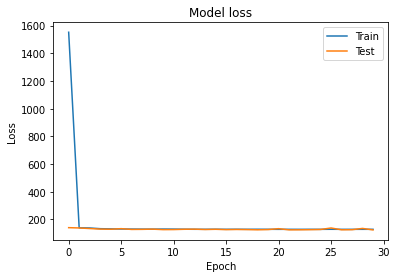

In [16]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test']) 
plt.show()

In [17]:
model.save("model_nn_1.h5")
#keras.models.load_model()

## Evaluation

In [18]:
model.evaluate(X_test_sc, Y_test)

471/471 [==============================] - 1s 1ms/step - loss: 125.3346 - mse: 124.3908


[125.33463287353516, 124.39076232910156]

In [19]:
pred = model.predict(X_test_sc).reshape((-1,))

In [20]:
obser = Y_test.DTSM
resid = obser - pred
residsq = resid**2

dtco = X_train

mean_res = np.mean(resid)
stdv_res = np.std(resid)

print("Residual mean:", mean_res)
print("Residual stdv:", stdv_res)
print_scores('Test',Y_test.DTSM, pred)

Residual mean: -0.35371655071000174
Residual stdv: 11.147450986793915
Test:	 MSE: 124.39, R^2 Score: 0.90, MAPE: 0.0561


In [21]:
idx = np.random.choice(np.arange(len(pred)), 2000, replace=False)
resid_sample = resid.to_numpy()[idx]
#resid_psample = resid_p[idx]
residsq_sample = residsq.to_numpy()[idx]
pred_sample = pred[idx]
obser_sample = obser.to_numpy()[idx]

pred_sort, resid_sort, residsq_sort, obser_sort = zip(*sorted(zip(pred_sample, resid_sample,residsq_sample, obser_sample)))
resid_sm = lowess(resid_sort,pred_sort, frac=0.4)[:,1]
residsq_sm = lowess(residsq_sort,pred_sort, frac=0.4)[:,1]
obser_sm = lowess(obser_sort,pred_sort, frac=0.4)[:,1]

In [22]:
def cm_wh(cmp_name):
  cmp = cm.get_cmap(cmp_name, 256)
  newcm = cmp(np.linspace(0, 1, 256))
  newcm[0, :] = np.array([1, 1, 1, 1])
  return ListedColormap(newcm)

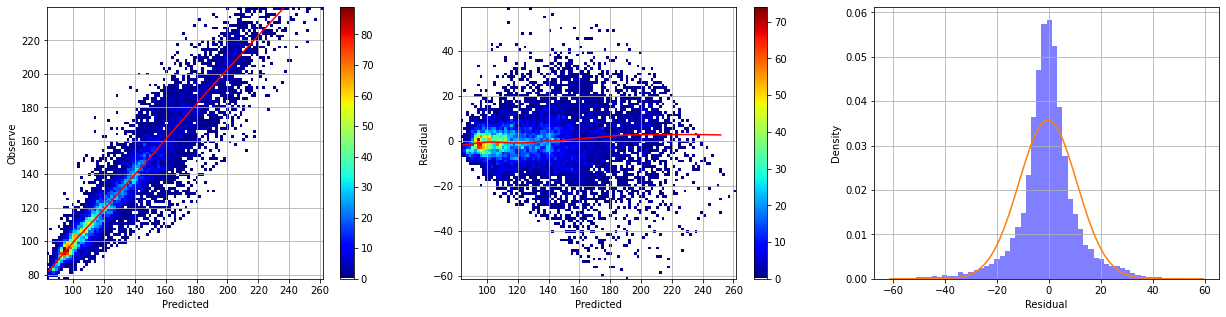

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,5))

h1=ax1.hist2d(pred, obser,bins=100, cmap=cm_wh('jet'))
ax1.plot(pred_sort, obser_sm, color='red')
#ax1.plot(x1, x1, color='black')
#ax1.axline([0, 0], [1, 1], color='white')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Observe")
ax1.grid()
fig.colorbar(h1[3], ax=ax1)

h2=ax2.hist2d(pred, resid,bins=100, cmap=cm_wh('jet'))
ax2.plot(pred_sort, resid_sm, color='red')
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Residual")
ax2.grid()
fig.colorbar(h2[3], ax=ax2)

n, bins, patches = ax3.hist(resid, 60, density=True, facecolor='blue', alpha=0.5)
ax3.plot(bins, norm.pdf(bins, mean_res, stdv_res))
ax3.set_xlabel("Residual")
ax3.set_ylabel("Density")
ax3.grid()

plt.show()

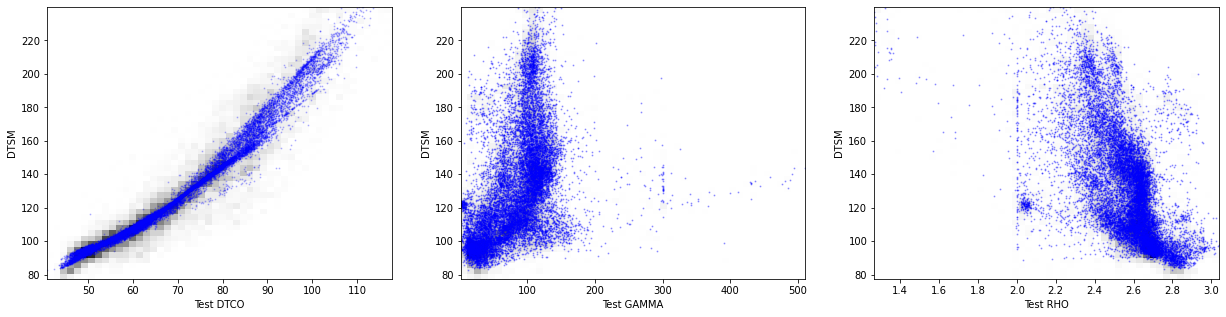

In [24]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(21,5))

#ax1.pcolormesh(X_tr, Y_tr, H_tr,cmap='binary')

ax1.hist2d(X_test.DTCO,Y_test.DTSM,bins=50, cmap='binary')
ax1.scatter(X_test.DTCO, pred, s=1, color='blue', alpha=0.2)
ax1.set_xlabel("Test DTCO")
ax1.set_ylabel("DTSM")

ax2.hist2d(X_test.GAMMA,Y_test.DTSM,bins=50, cmap='binary')
#ax2.hist2d(X_test.GAMMA,pred,bins=50, cmap=cm_wh('jet'), alpha=0.3)
ax2.scatter(X_test.GAMMA, pred, s=1, color='blue', alpha=0.3)
ax2.set_xlabel("Test GAMMA")
ax2.set_ylabel("DTSM")

ax3.hist2d(X_test.RHO,Y_test.DTSM,bins=50, cmap='binary')
ax3.scatter(X_test.RHO, pred, s=1, color='blue', alpha=0.3)
ax3.set_xlabel("Test RHO")
ax3.set_ylabel("DTSM");

## Reference
[1] 
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb

[2]
https://keras-team.github.io/keras-tuner/

[3]
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/




